In [45]:
import pandas as pd
from scipy.stats import ttest_ind, levene, mannwhitneyu,shapiro
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
import seaborn as sns
import matplotlib.ticker as mticker


pd.set_option('display.max_columns', None)

In [46]:
dtp = pd.read_csv('dtp_clear.csv')
dtp

,REGION,DATE,COORD_L,COORD_W,road_name,road_category,n_VEHICLES,n_PARTICIPANTS,ID,n_DEATHS,n_INJURED,vehicle_failure,non_private_vehicle,russian_vehicle,white_vehicle,black_vehicle,colored_vehicle,drunk_driver,female_driver,escaped,no_seatbelt_injury,n_drunk,n_children,n_cyclists,n_pedestrians,vehicle_age_min,vehicle_age_max,vehicle_age_avg,n_class_a,n_class_b,n_class_c,n_class_d,n_class_e,n_class_s,n_front_drive,n_rear_drive,n_4wd,n_guilty,guilty_share,n_fatal_violations,guilty_exp_avg,exp_avg,road_rank_cat,road_defects_cat,traffic_changes_bin,traffic_changes_cat,road_surface_cat,TYPE_cat,out_of_town,street_rank_cat,weather_interpretable,weather_cat,adj_objects_interpretable,adj_objects_cat,cause_factors_cat,crossing_violation,impaired_driving,interference_violation,license_violation,maneuver_violation,other_violation,pedestrian_violation,sudden_appearance_violation,traffic_control_violation,transport_violation,vehicle_tech_violation,wrong_way,no_lighting,lighting_cat,site_objects_cat,severity,YEAR,MONTH,WEEKDAY,SEASON,is_WEEKEND,HOUR,is_NIGHT,is_PEAK_HOUR,max_car_age,all_auto
0,1,31.01.2015,81.151944,53.740000,Романово - Завьялово - Баево - Камень-на-Оби,5.0,1,3,161242174,0,3,0,0,0,0,0,1,0,0,1,1,0,0,0,0,2003,2003.0,2003.0,0,1,0,0,0,0,0,0,0,1,1.0,4,17.0,17.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,1,0,0,0,1,0,0,0,4,12,2,2015,1,5,1,1,9,0,1,12,1
1,1,30.01.2015,85.018056,51.684444,Куяган - Куяча - Тоурак,6.0,2,3,161105683,0,2,0,1,0,1,0,1,0,0,0,0,0,0,0,0,2002,2004.0,2003.0,1,0,0,0,0,0,0,0,0,1,0.5,1,7.0,10.0,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,2,2015,1,4,1,0,14,0,0,13,0
2,1,30.01.2015,81.250000,53.818056,Барнаул - Камень-на-Оби - граница Новосибирско...,5.0,2,3,161763431,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,2005,2008.0,2006.5,0,1,0,0,0,0,0,0,0,1,0.5,1,2.0,15.5,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,1,2015,1,4,1,0,17,0,1,10,0
3,1,24.01.2015,51.000000,84.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160331994,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,2000,2000.0,2000.0,0,1,0,0,0,0,0,0,0,1,1.0,2,26.0,26.0,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,1,0,0,0,0,0,0,1,0,0,0,1,2,12,1,2015,1,5,1,1,19,0,0,15,1
4,1,23.01.2015,84.000000,53.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160213415,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2003,2003.0,2003.0,0,1,0,0,0,0,0,0,0,1,1.0,1,18.0,18.0,3,5,0,2,1,7,1,0,LOW_VISIBILITY,3,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,12,3,2015,1,4,1,0,21,0,0,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426484,10011,18.12.2022,55.731164,67.417464,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",5.0,1,1,222679998,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,2020,2020.0,2020.0,0,0,0,0,0,0,0,0,1,1,1.0,1,31.0,31.0,3,5,0,2,1,7,1,4,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,3,3,2022,12,6,1,1,15,0,0,2,0
426485,10011,16.06.2024,54.095821,67.629532,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",6.0,1,2,223892751,0,2,0,0,0,0,1,0,1,0,0,1,2,0,0,0,2023,2023.0,2023.0,0,0,0,1,0,0,0,0,1,1,1.0,4,8.0,8.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,1,1,0,0,0,0,12,1,2024,6,6,3,1,9,0,1,1,1
426486,10011,04.07.2024,53.607541,67.836463,Подъездная автомобильная дорога к п. Красное,1.0,1,1,223948754,0,1,0,0,0,0,0,1,1,1,0,1,1,0,0,0,2011,2011.0,2011.0,0,0,0,0,0,0,0,0,0,1,1.0,1,24.0,24.0,3,13,0,2,2,7,1,4,LOW_VISIBILITY,3,LIVING_OBJ,1,18,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,2,2024,7,3,3,0,9,0,1,13,0
426487,10011,25.08.2024,53.612724,67.837285,Подъездная автомобильная дорога к п. Красное,4.0,1,1,224161731,0,1,0,0,0,0,0,1,1,0,0,1,1,0,0,0,2024,2024.0,2024.0,0,0,0,0,0,0,0,0,0,1,1.0,4,95.0,95.0,3,5,0,2,7,4,1,4,nothing,5,SOCIAL_OBJ,3,18,0,0,0,1,0,1,0,0,1,1,0,0,0,0,12,1,2024,8,6,3,1,14,

In [47]:
dtp = dtp.drop(dtp.loc[dtp.n_cyclists > 0].index)

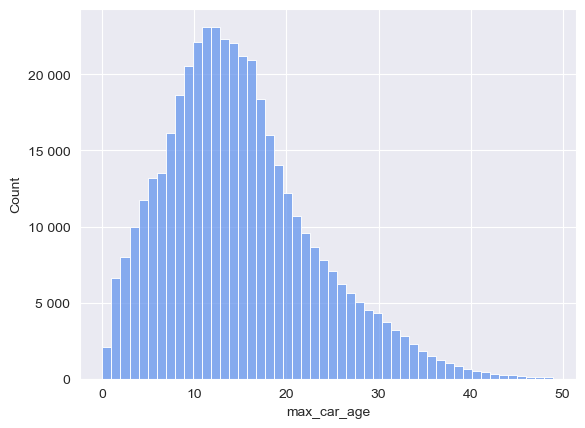

In [48]:
sns.histplot(dtp['max_car_age'], bins = 50, color = '#6495ed')
# формат: 10 000 вместо 10000
plt.gca().yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, pos: f'{int(x):,}'.replace(',', ' '))
)

plt.show()

In [49]:
dtp['severity'] = dtp['severity'].astype('str')

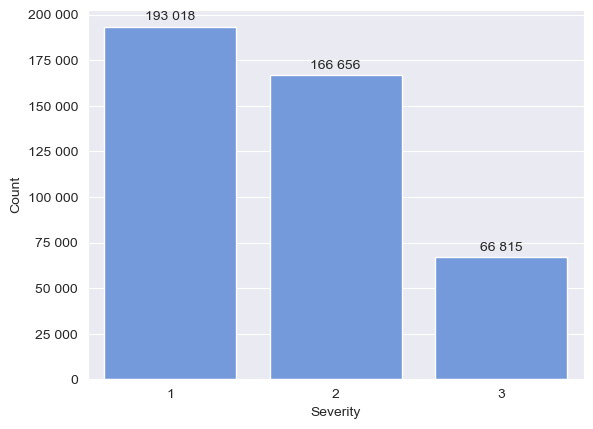

In [50]:
ax = sns.countplot(data = dtp, x = 'severity', color = '#6495ed', order = ['1', '2', '3'])

ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, pos: f'{int(x):,}'.replace(',', ' '))
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{int(height):,}'.replace(',', ' '),
        (p.get_x() + p.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=10,
        xytext=(0, 3),
        textcoords='offset points'
    )

plt.xlabel('Severity')
plt.ylabel('Count')

plt.show()

In [51]:
dtp['severity'] = dtp['severity'].astype('int')

In [52]:
dtp_mean = dtp.groupby('max_car_age', as_index = False).agg({'severity': 'mean'})

<Axes: xlabel='max_car_age', ylabel='severity'>

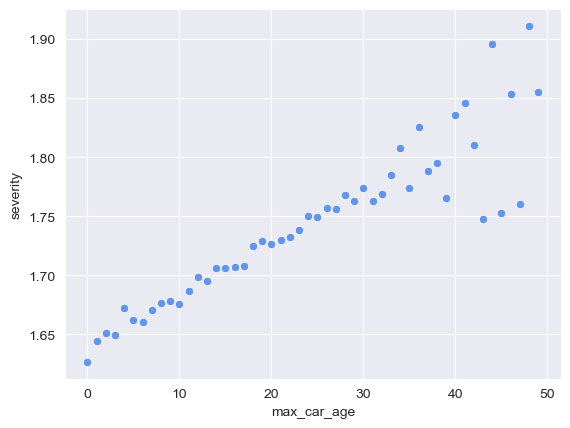

In [53]:
sns.scatterplot(data = dtp_mean, x = 'max_car_age', y = 'severity', color = '#6495ed')

In [54]:
dtp_mean.corr(method = 'spearman')

,max_car_age,severity
max_car_age,1.000000,0.935942
severity,0.935942,1.000000


In [55]:
def check_linear_regression(data, target, predictors):
    X = data[predictors]
    y = data[target]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit(cov_type='HC3')
    print(model.summary())
    
    # 1. Проверка нормальности остатков
    residuals = model.resid
    stat, p = shapiro(residuals)
    print(f"Shapiro-Wilk Test for Normality: Statistic={stat:.4f}, p-value={p:.4f}")
    if p > 0.05:
        print("Residuals follow a normal distribution.")
    else:
        print("Residuals do not follow a normal distribution.")
    
    # Q-Q Plot
    sm.qqplot(residuals, line='s')
    plt.title('Q-Q Plot of Residuals')
    plt.show()
    
    # 2. Проверка постоянства дисперсии (гомоскедастичности)
    _, pval, _, _ = het_breuschpagan(residuals, X)
    print(f"Breusch-Pagan Test for Homoscedasticity: p-value={pval:.4f}")
    if pval > 0.05:
        print("Residuals are homoscedastic.")
    else:
        print("Residuals are heteroscedastic.")
    
    # 4. Проверка линейности
    sns.residplot(x=model.predict(X), y=residuals, lowess=True, line_kws={'color': 'red'})
    plt.title('Residuals vs Fitted')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.show()

                            OLS Regression Results                            
Dep. Variable:               severity   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     121.5
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           9.52e-15
Time:                        08:52:36   Log-Likelihood:                 111.15
No. Observations:                  50   AIC:                            -218.3
Df Residuals:                      48   BIC:                            -214.5
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.6424      0.006    288.056      

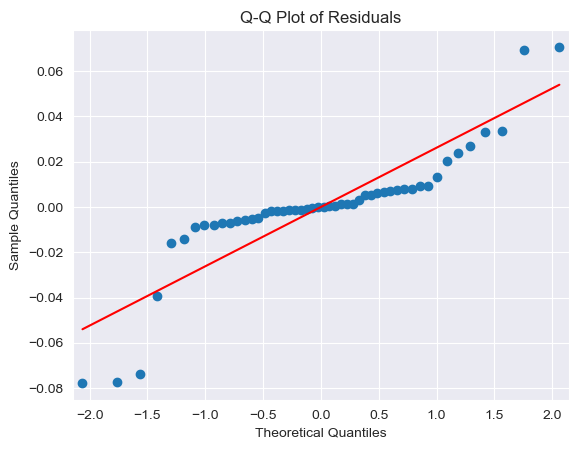

Breusch-Pagan Test for Homoscedasticity: p-value=0.0001
Residuals are heteroscedastic.


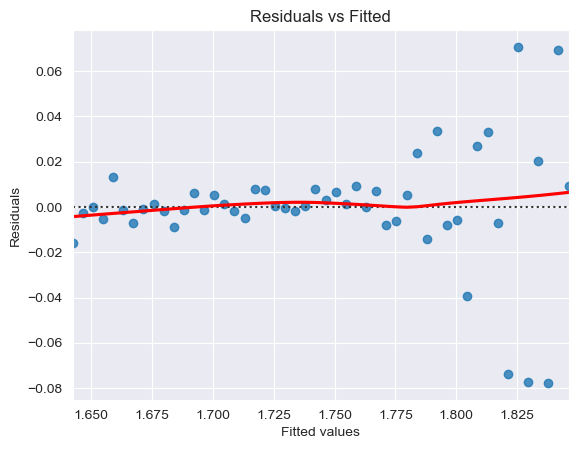

In [56]:
check_linear_regression(dtp_mean, 'severity', 'max_car_age')

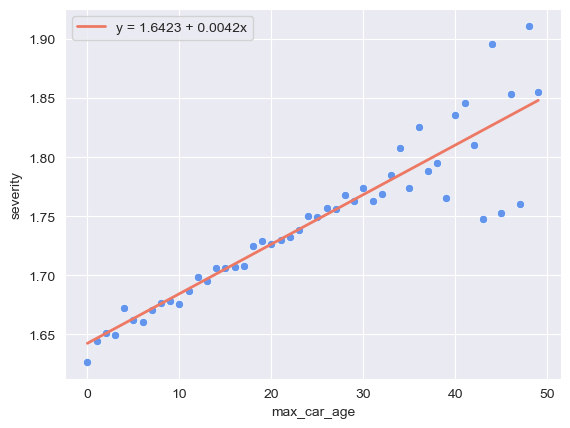

In [57]:
sns.scatterplot(data=dtp_mean, x='max_car_age', y='severity', color = '#6495ed')

x_vals = np.linspace(dtp_mean['max_car_age'].min(),
                     dtp_mean['max_car_age'].max(), 100)

y_vals = 1.6423 + 0.0042 * x_vals

plt.plot(x_vals, y_vals, linewidth=2, label='y = 1.6423 + 0.0042x', color = '#ed7864')

plt.legend()
plt.show()

In [58]:
dtp

,REGION,DATE,COORD_L,COORD_W,road_name,road_category,n_VEHICLES,n_PARTICIPANTS,ID,n_DEATHS,n_INJURED,vehicle_failure,non_private_vehicle,russian_vehicle,white_vehicle,black_vehicle,colored_vehicle,drunk_driver,female_driver,escaped,no_seatbelt_injury,n_drunk,n_children,n_cyclists,n_pedestrians,vehicle_age_min,vehicle_age_max,vehicle_age_avg,n_class_a,n_class_b,n_class_c,n_class_d,n_class_e,n_class_s,n_front_drive,n_rear_drive,n_4wd,n_guilty,guilty_share,n_fatal_violations,guilty_exp_avg,exp_avg,road_rank_cat,road_defects_cat,traffic_changes_bin,traffic_changes_cat,road_surface_cat,TYPE_cat,out_of_town,street_rank_cat,weather_interpretable,weather_cat,adj_objects_interpretable,adj_objects_cat,cause_factors_cat,crossing_violation,impaired_driving,interference_violation,license_violation,maneuver_violation,other_violation,pedestrian_violation,sudden_appearance_violation,traffic_control_violation,transport_violation,vehicle_tech_violation,wrong_way,no_lighting,lighting_cat,site_objects_cat,severity,YEAR,MONTH,WEEKDAY,SEASON,is_WEEKEND,HOUR,is_NIGHT,is_PEAK_HOUR,max_car_age,all_auto
0,1,31.01.2015,81.151944,53.740000,Романово - Завьялово - Баево - Камень-на-Оби,5.0,1,3,161242174,0,3,0,0,0,0,0,1,0,0,1,1,0,0,0,0,2003,2003.0,2003.0,0,1,0,0,0,0,0,0,0,1,1.0,4,17.0,17.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,1,0,0,0,1,0,0,0,4,12,2,2015,1,5,1,1,9,0,1,12,1
1,1,30.01.2015,85.018056,51.684444,Куяган - Куяча - Тоурак,6.0,2,3,161105683,0,2,0,1,0,1,0,1,0,0,0,0,0,0,0,0,2002,2004.0,2003.0,1,0,0,0,0,0,0,0,0,1,0.5,1,7.0,10.0,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,2,2015,1,4,1,0,14,0,0,13,0
2,1,30.01.2015,81.250000,53.818056,Барнаул - Камень-на-Оби - граница Новосибирско...,5.0,2,3,161763431,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,2005,2008.0,2006.5,0,1,0,0,0,0,0,0,0,1,0.5,1,2.0,15.5,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,1,2015,1,4,1,0,17,0,1,10,0
3,1,24.01.2015,51.000000,84.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160331994,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,2000,2000.0,2000.0,0,1,0,0,0,0,0,0,0,1,1.0,2,26.0,26.0,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,1,0,0,0,0,0,0,1,0,0,0,1,2,12,1,2015,1,5,1,1,19,0,0,15,1
4,1,23.01.2015,84.000000,53.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160213415,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2003,2003.0,2003.0,0,1,0,0,0,0,0,0,0,1,1.0,1,18.0,18.0,3,5,0,2,1,7,1,0,LOW_VISIBILITY,3,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,12,3,2015,1,4,1,0,21,0,0,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426484,10011,18.12.2022,55.731164,67.417464,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",5.0,1,1,222679998,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,2020,2020.0,2020.0,0,0,0,0,0,0,0,0,1,1,1.0,1,31.0,31.0,3,5,0,2,1,7,1,4,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,3,3,2022,12,6,1,1,15,0,0,2,0
426485,10011,16.06.2024,54.095821,67.629532,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",6.0,1,2,223892751,0,2,0,0,0,0,1,0,1,0,0,1,2,0,0,0,2023,2023.0,2023.0,0,0,0,1,0,0,0,0,1,1,1.0,4,8.0,8.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,1,1,0,0,0,0,12,1,2024,6,6,3,1,9,0,1,1,1
426486,10011,04.07.2024,53.607541,67.836463,Подъездная автомобильная дорога к п. Красное,1.0,1,1,223948754,0,1,0,0,0,0,0,1,1,1,0,1,1,0,0,0,2011,2011.0,2011.0,0,0,0,0,0,0,0,0,0,1,1.0,1,24.0,24.0,3,13,0,2,2,7,1,4,LOW_VISIBILITY,3,LIVING_OBJ,1,18,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,2,2024,7,3,3,0,9,0,1,13,0
426487,10011,25.08.2024,53.612724,67.837285,Подъездная автомобильная дорога к п. Красное,4.0,1,1,224161731,0,1,0,0,0,0,0,1,1,0,0,1,1,0,0,0,2024,2024.0,2024.0,0,0,0,0,0,0,0,0,0,1,1.0,4,95.0,95.0,3,5,0,2,7,4,1,4,nothing,5,SOCIAL_OBJ,3,18,0,0,0,1,0,1,0,0,1,1,0,0,0,0,12,1,2024,8,6,3,1,14,

In [59]:
dtp.loc[dtp['all_auto'] == 1]

,REGION,DATE,COORD_L,COORD_W,road_name,road_category,n_VEHICLES,n_PARTICIPANTS,ID,n_DEATHS,n_INJURED,vehicle_failure,non_private_vehicle,russian_vehicle,white_vehicle,black_vehicle,colored_vehicle,drunk_driver,female_driver,escaped,no_seatbelt_injury,n_drunk,n_children,n_cyclists,n_pedestrians,vehicle_age_min,vehicle_age_max,vehicle_age_avg,n_class_a,n_class_b,n_class_c,n_class_d,n_class_e,n_class_s,n_front_drive,n_rear_drive,n_4wd,n_guilty,guilty_share,n_fatal_violations,guilty_exp_avg,exp_avg,road_rank_cat,road_defects_cat,traffic_changes_bin,traffic_changes_cat,road_surface_cat,TYPE_cat,out_of_town,street_rank_cat,weather_interpretable,weather_cat,adj_objects_interpretable,adj_objects_cat,cause_factors_cat,crossing_violation,impaired_driving,interference_violation,license_violation,maneuver_violation,other_violation,pedestrian_violation,sudden_appearance_violation,traffic_control_violation,transport_violation,vehicle_tech_violation,wrong_way,no_lighting,lighting_cat,site_objects_cat,severity,YEAR,MONTH,WEEKDAY,SEASON,is_WEEKEND,HOUR,is_NIGHT,is_PEAK_HOUR,max_car_age,all_auto
0,1,31.01.2015,81.151944,53.740000,Романово - Завьялово - Баево - Камень-на-Оби,5.0,1,3,161242174,0,3,0,0,0,0,0,1,0,0,1,1,0,0,0,0,2003,2003.0,2003.000000,0,1,0,0,0,0,0,0,0,1,1.000000,4,17.0,17.000000,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,1,0,0,0,1,0,0,0,4,12,2,2015,1,5,1,1,9,0,1,12,1
3,1,24.01.2015,51.000000,84.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160331994,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,2000,2000.0,2000.000000,0,1,0,0,0,0,0,0,0,1,1.000000,2,26.0,26.000000,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,1,0,0,0,0,0,0,1,0,0,0,1,2,12,1,2015,1,5,1,1,19,0,0,15,1
4,1,23.01.2015,84.000000,53.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160213415,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2003,2003.0,2003.000000,0,1,0,0,0,0,0,0,0,1,1.000000,1,18.0,18.000000,3,5,0,2,1,7,1,0,LOW_VISIBILITY,3,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,12,3,2015,1,4,1,0,21,0,0,12,1
6,1,21.01.2015,82.475000,52.268889,А-322 Барнаул - Рубцовск - граница с Республик...,3.0,2,2,159912220,0,1,0,0,0,0,1,1,1,0,0,0,2,0,0,0,2001,2008.0,2004.500000,0,2,0,0,0,0,0,0,0,1,0.500000,1,22.0,27.000000,4,5,0,2,1,7,1,0,SMOW,2,no_obj,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,12,1,2015,1,2,1,0,12,0,0,14,1
9,1,21.01.2015,83.000000,53.000000,Р-256 подъезд к городу Барнаул от а/д Р-256,3.0,3,4,159748195,0,1,0,0,0,1,0,0,1,0,0,1,3,0,0,0,1991,2007.0,1999.333333,1,1,1,0,0,0,0,0,0,1,0.333333,3,19.0,11.666667,4,5,1,1,1,4,1,0,SMOW,2,no_obj,4,18,0,0,0,0,0,0,0,0,1,1,0,0,0,4,3,1,2015,1,2,1,0,7,0,1,24,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426465,10011,27.09.2020,53.521056,67.715305,Подъездная автомобильная дорога к п. Красное,7.0,1,1,220926920,1,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,2010,2010.0,2010.000000,0,1,0,0,0,0,1,0,0,1,1.000000,5,0.0,0.000000,3,5,0,2,2,7,1,0,LOW_VISIBILITY,3,no_obj,4,18,0,1,0,0,0,1,0,0,1,1,0,0,0,2,12,3,2020,9,6,4,1,1,1,0,10,1
426470,10011,01.04.2021,53.103822,67.667859,г. Нарьян-Мар - п. Искателей,5.0,1,1,221349607,1,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,2005,2005.0,2005.000000,0,1,0,0,0,0,0,0,1,1,1.000000,3,4.0,4.000000,3,2,1,1,0,7,1,4,nothing,5,LIVING_OBJ,1,18,0,1,0,0,0,0,0,0,1,0,0,1,0,3,12,3,2021,4,3,2,0,3,1,0,16,1
426475,10011,11.08.2021,53.632615,67.831416,Подъездная автомобильная дорога к п. Красное,8.0,1,1,221628546,0,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,2002,2002.0,2002.000000,1,0,0,0,0,0,1,0,0,1,1.000000,2,0.0,0.000000,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,1,0,0,0,0,0,0,0,0,0,1,0,4,12,2,2021,8,2,3,0,0,1,0,19,1
426478,10011,29.01.2022,53.045779,67.646810,г. Нарьян-Мар - п. Искателей,5.0,2,3,222039144,0,2,0,0,0,0,1,1,0,1,0,0,0,0,0,0,2004,2008.0,2006.000000,0,2,0,0,0,0,1,0,1,1,0.500000,1,4.0,8.5

In [60]:
dtp_mean_all_auto = dtp.groupby(['max_car_age', 'all_auto'], as_index = False).agg({'severity': 'mean'})

In [61]:
dtp_mean_all_auto_ch = dtp_mean_all_auto.loc[dtp_mean_all_auto.severity < 2].copy()

<Axes: xlabel='max_car_age', ylabel='severity'>

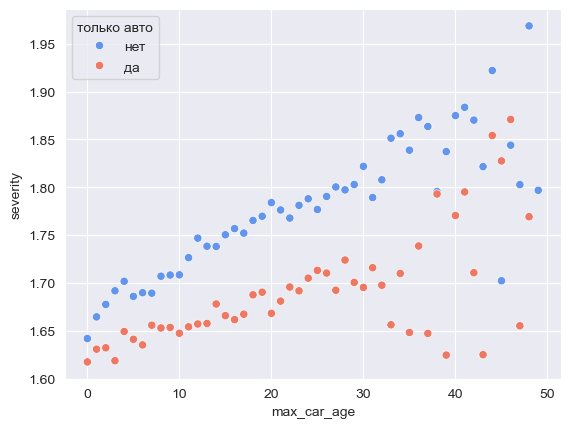

In [62]:
dtp_mean_all_auto_ch['только авто'] = dtp_mean_all_auto_ch['all_auto'].map({
    1: 'да',
    0: 'нет'
})

sns.scatterplot(
    data=dtp_mean_all_auto_ch,
    x='max_car_age',
    y='severity',
    hue='только авто',     palette={
        'нет': '#6495ed',   # синий
        'да': '#ed7864'  # красный
    }
)

In [63]:
def normal_means(s):
    choice_iterations = 1000000
    sample_size = 100
    shapiro_iterations = 25
    unique_elems = s.unique()
    arr = pd.Series([np.random.choice(unique_elems, len(s)).mean() for _ in range(choice_iterations)])
    return np.mean([shapiro(arr.sample(sample_size))[1] for _ in range(shapiro_iterations)])

def equal_var(*s):
    p_levene = levene(*s)[-1]
    if p_levene > 0.05:
        print('Дисперсии выборок равны')
    else:
        print('Дисперсии выборок не равны') 
    return p_levene

def compare_mean(df, col1, col2):
    s1 = df[col1]
    s2 = df[col2]
    p_normal_means_s1 = normal_means(s1)
    p_normal_means_s12 = normal_means(s2)
    p_equal_var = equal_var(s1, s2)
    print('p_normal_means_s1:', p_normal_means_s1)
    print('p_normal_means_s12:', p_normal_means_s12)
    print('p_equal_var:', p_equal_var)
    if p_normal_means_s1 > 0.05 and p_normal_means_s12 > 0.05:
        if p_equal_var > 0.05:
            print('Т-Критерий Стьюдента')
            p_test = ttest_ind(s1, s2, equal_var=True)[-1]
        else:
            print('Т-Критерий Уэлча')
            p_test = ttest_ind(s1, s2, equal_var=False)[-1]
    else:
        print('U-критерий Манна-Уитни')
        p_test = mannwhitneyu(s1, s2)[-1]
    print('p-value:', p_test)
    if p_test <= 0.05:
        print('Средние стат. значимо отличаются')
    else:
        print('Средние стат. значимо НЕ отличаются')

In [64]:
dtp_mean_all = dtp_mean_all_auto_ch.copy()
dtp_mean_all = dtp_mean_all.drop(dtp_mean_all.loc[dtp_mean_all.all_auto == 0].index)
dtp_mean_not_all = dtp_mean_all_auto_ch.copy()
dtp_mean_not_all = dtp_mean_not_all.drop(dtp_mean_not_all.loc[dtp_mean_not_all.all_auto == 1].index)

In [65]:
dtp_kruto = dtp_mean_not_all.merge(dtp_mean_all, on = 'max_car_age')

In [66]:
compare_mean(dtp_kruto, 'severity_x', 'severity_y')

Дисперсии выборок равны
p_normal_means_s1: 0.4615327477445731
p_normal_means_s12: 0.5201673720011855
p_equal_var: 0.13464733459995468
Т-Критерий Стьюдента
p-value: 1.2424220291013449e-09
Средние стат. значимо отличаются


                            OLS Regression Results                            
Dep. Variable:               severity   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     19.93
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           5.01e-05
Time:                        08:52:51   Log-Likelihood:                 83.227
No. Observations:                  49   AIC:                            -162.5
Df Residuals:                      47   BIC:                            -158.7
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.6247      0.009    186.987      

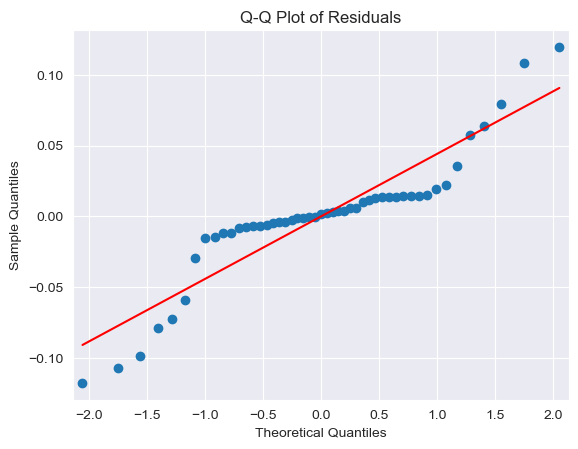

Breusch-Pagan Test for Homoscedasticity: p-value=0.0000
Residuals are heteroscedastic.


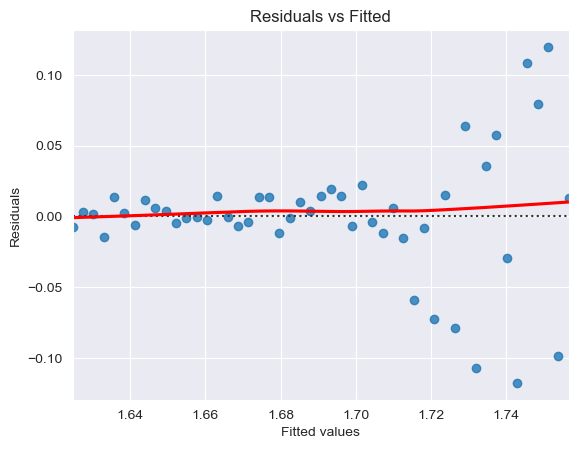

In [67]:
check_linear_regression(dtp_mean_all, 'severity', 'max_car_age')

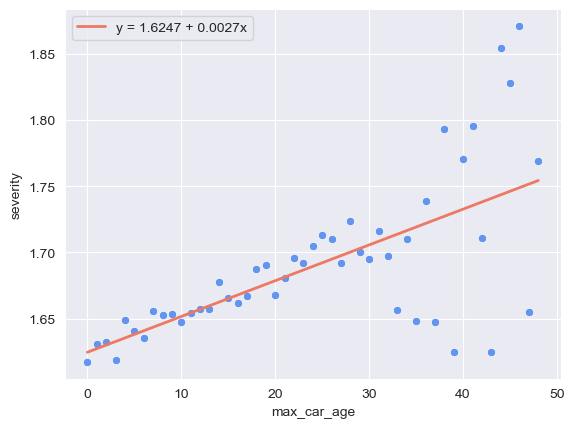

In [68]:
sns.scatterplot(data = dtp_mean_all, x = 'max_car_age', y = 'severity', color = '#6495ed')

# диапазон x берём по данным
x_vals = np.linspace(dtp_mean_all['max_car_age'].min(),
                     dtp_mean_all['max_car_age'].max(), 100)

y_vals = 1.6247 + 0.0027 * x_vals

plt.plot(x_vals, y_vals, linewidth=2, label='y = 1.6247 + 0.0027x', color = '#ed7864')

plt.legend()
plt.show()

In [69]:
dtp_mean_all.corr(numeric_only = True, method = 'spearman')

,max_car_age,all_auto,severity
max_car_age,1.000000,NaN,0.633673
all_auto,NaN,NaN,NaN
severity,0.633673,NaN,1.000000


                            OLS Regression Results                            
Dep. Variable:               severity   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     57.18
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           1.02e-09
Time:                        08:52:51   Log-Likelihood:                 94.099
No. Observations:                  50   AIC:                            -184.2
Df Residuals:                      48   BIC:                            -180.4
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.6798      0.009    188.423      

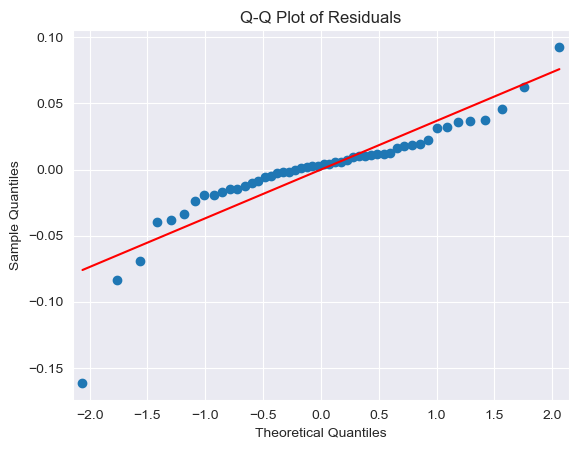

Breusch-Pagan Test for Homoscedasticity: p-value=0.0031
Residuals are heteroscedastic.


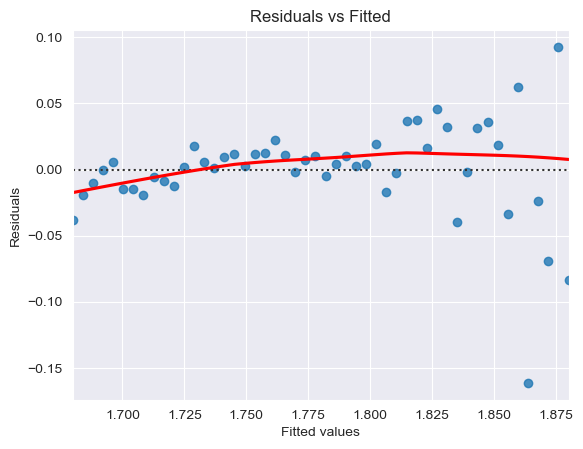

In [70]:
check_linear_regression(dtp_mean_not_all, 'severity', 'max_car_age')

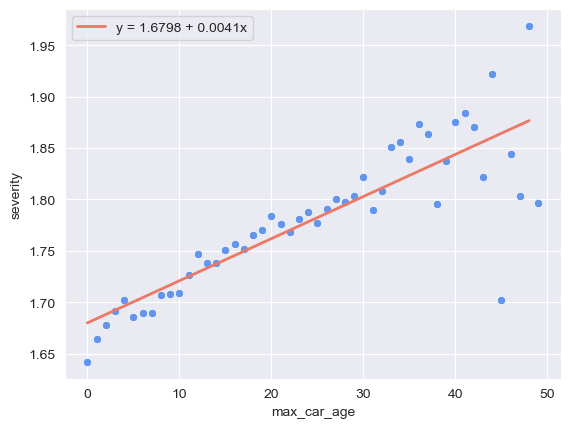

In [71]:
sns.scatterplot(data = dtp_mean_not_all, x = 'max_car_age', y = 'severity', color = '#6495ed')

# диапазон x берём по данным
x_vals = np.linspace(dtp_mean_all['max_car_age'].min(),
                     dtp_mean_all['max_car_age'].max(), 100)

y_vals = 1.6798 + 0.0041 * x_vals

plt.plot(x_vals, y_vals, linewidth=2, label='y = 1.6798 + 0.0041x', color = '#ed7864')

plt.legend()
plt.show()

In [72]:
dtp_mean_not_all.corr(numeric_only = True, method = 'spearman')

,max_car_age,all_auto,severity
max_car_age,1.000000,NaN,0.871309
all_auto,NaN,NaN,NaN
severity,0.871309,NaN,1.000000


In [73]:
dtp['is_lob'] = ((dtp['wrong_way'] == 1) & (dtp['n_VEHICLES'] > 1)).astype(int)

In [74]:
dtp_lob = dtp.loc[dtp.is_lob == 1]
dtp_not_lob = dtp.loc[dtp.is_lob == 0]

In [75]:
dtp_lob

,REGION,DATE,COORD_L,COORD_W,road_name,road_category,n_VEHICLES,n_PARTICIPANTS,ID,n_DEATHS,n_INJURED,vehicle_failure,non_private_vehicle,russian_vehicle,white_vehicle,black_vehicle,colored_vehicle,drunk_driver,female_driver,escaped,no_seatbelt_injury,n_drunk,n_children,n_cyclists,n_pedestrians,vehicle_age_min,vehicle_age_max,vehicle_age_avg,n_class_a,n_class_b,n_class_c,n_class_d,n_class_e,n_class_s,n_front_drive,n_rear_drive,n_4wd,n_guilty,guilty_share,n_fatal_violations,guilty_exp_avg,exp_avg,road_rank_cat,road_defects_cat,traffic_changes_bin,traffic_changes_cat,road_surface_cat,TYPE_cat,out_of_town,street_rank_cat,weather_interpretable,weather_cat,adj_objects_interpretable,adj_objects_cat,cause_factors_cat,crossing_violation,impaired_driving,interference_violation,license_violation,maneuver_violation,other_violation,pedestrian_violation,sudden_appearance_violation,traffic_control_violation,transport_violation,vehicle_tech_violation,wrong_way,no_lighting,lighting_cat,site_objects_cat,severity,YEAR,MONTH,WEEKDAY,SEASON,is_WEEKEND,HOUR,is_NIGHT,is_PEAK_HOUR,max_car_age,all_auto,is_lob
1,1,30.01.2015,85.018056,51.684444,Куяган - Куяча - Тоурак,6.0,2,3,161105683,0,2,0,1,0,1,0,1,0,0,0,0,0,0,0,0,2002,2004.0,2003.0,1,0,0,0,0,0,0,0,0,1,0.5,1,7.0,10.0,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,2,2015,1,4,1,0,14,0,0,13,0,1
2,1,30.01.2015,81.250000,53.818056,Барнаул - Камень-на-Оби - граница Новосибирско...,5.0,2,3,161763431,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,2005,2008.0,2006.5,0,1,0,0,0,0,0,0,0,1,0.5,1,2.0,15.5,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,1,2015,1,4,1,0,17,0,1,10,0,1
10,1,21.01.2015,83.053056,53.285556,Барнаул - Камень-на-Оби - граница Новосибирско...,5.0,2,3,159748203,2,0,0,0,0,0,0,1,1,0,0,0,2,0,0,0,1994,2004.0,1999.0,0,1,0,0,0,0,0,0,0,1,0.5,3,30.0,17.5,3,5,0,2,1,7,1,0,SMOW,2,no_obj,4,18,0,0,0,0,1,1,0,0,0,0,0,1,0,0,12,3,2015,1,2,1,0,11,0,0,21,0,1
16,1,20.01.2015,85.365000,52.378889,Бийск - Карабинка - граница Республики Алтай,5.0,2,3,159748151,1,2,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1996,2007.0,2001.5,0,2,0,0,0,0,0,0,0,1,0.5,2,2.0,18.5,3,5,0,2,4,7,1,0,LOW_VISIBILITY,3,no_obj,4,18,0,0,0,0,0,1,0,0,0,0,0,1,0,4,12,3,2015,1,1,1,0,8,0,1,19,1,1
17,1,18.01.2015,83.704444,53.299444,Объездная дорога в обход г. Барнаула,4.0,2,7,159747915,2,5,0,1,0,1,0,0,0,0,0,0,0,0,0,0,2011,2011.0,2011.0,0,1,1,0,0,0,0,0,0,1,0.5,1,5.0,8.5,3,5,1,1,2,7,0,3,SMOW,2,TRANSPORT_OBJ,9,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,3,2015,1,6,1,1,9,0,1,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426473,10011,24.08.2021,53.098100,67.667800,г. Нарьян-Мар - п. Искателей,5.0,2,3,221671315,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1985,2013.0,1999.0,0,1,0,0,0,0,1,1,0,1,0.5,2,18.0,11.5,3,6,1,1,2,7,1,2,LOW_VISIBILITY,3,no_obj,4,18,0,0,0,0,1,0,0,0,0,0,0,1,0,0,6,1,2021,8,1,3,0,7,0,1,36,0,1
426478,10011,29.01.2022,53.045779,67.646810,г. Нарьян-Мар - п. Искателей,5.0,2,3,222039144,0,2,0,0,0,0,1,1,0,1,0,0,0,0,0,0,2004,2008.0,2006.0,0,2,0,0,0,0,1,0,1,1,0.5,1,4.0,8.5,3,5,0,2,7,7,1,2,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,3,11,1,2022,1,5,1,1,23,1,0,18,1,1
426479,10011,01.01.2022,56.245752,67.242043,"г. Нарьян-Мар - г. Усинск, участок п. Харьягин...",1.0,2,6,221973148,0,1,0,0,0,1,0,1,0,0,0,0,0,3,0,0,2001,2015.0,2008.0,0,0,0,0,0,0,0,0,1,1,0.5,1,4.0,10.5,3,5,0,2,1,7,1,4,SMOW,2,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,1,2022,1,5,1,1,13,0,0,21,0,1
426481,10011,15.08.2022,53.969736,67.933235,"г. Нарьян-Мар - г. Усинск, искусственное дорож...",5.0,2,2,222473626,0,1,1,0,0,0,1,1,1,0,0,1,1,0,0,0,1986,2004.0,1995.0,0,1,0,0,0,0,0,0,1,1,0.5,5,95.0,53.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,1,0,1,0,1,0,0,0,1,0,1,0,0,12,2,2022,8,0,3,0,22,1,0,36,0,1


In [76]:
dtp_not_lob

,REGION,DATE,COORD_L,COORD_W,road_name,road_category,n_VEHICLES,n_PARTICIPANTS,ID,n_DEATHS,n_INJURED,vehicle_failure,non_private_vehicle,russian_vehicle,white_vehicle,black_vehicle,colored_vehicle,drunk_driver,female_driver,escaped,no_seatbelt_injury,n_drunk,n_children,n_cyclists,n_pedestrians,vehicle_age_min,vehicle_age_max,vehicle_age_avg,n_class_a,n_class_b,n_class_c,n_class_d,n_class_e,n_class_s,n_front_drive,n_rear_drive,n_4wd,n_guilty,guilty_share,n_fatal_violations,guilty_exp_avg,exp_avg,road_rank_cat,road_defects_cat,traffic_changes_bin,traffic_changes_cat,road_surface_cat,TYPE_cat,out_of_town,street_rank_cat,weather_interpretable,weather_cat,adj_objects_interpretable,adj_objects_cat,cause_factors_cat,crossing_violation,impaired_driving,interference_violation,license_violation,maneuver_violation,other_violation,pedestrian_violation,sudden_appearance_violation,traffic_control_violation,transport_violation,vehicle_tech_violation,wrong_way,no_lighting,lighting_cat,site_objects_cat,severity,YEAR,MONTH,WEEKDAY,SEASON,is_WEEKEND,HOUR,is_NIGHT,is_PEAK_HOUR,max_car_age,all_auto,is_lob
0,1,31.01.2015,81.151944,53.740000,Романово - Завьялово - Баево - Камень-на-Оби,5.0,1,3,161242174,0,3,0,0,0,0,0,1,0,0,1,1,0,0,0,0,2003,2003.0,2003.0,0,1,0,0,0,0,0,0,0,1,1.0,4,17.0,17.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,1,0,0,0,1,0,0,0,4,12,2,2015,1,5,1,1,9,0,1,12,1,0
3,1,24.01.2015,51.000000,84.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160331994,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,2000,2000.0,2000.0,0,1,0,0,0,0,0,0,0,1,1.0,2,26.0,26.0,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,1,0,0,0,0,0,0,1,0,0,0,1,2,12,1,2015,1,5,1,1,19,0,0,15,1,0
4,1,23.01.2015,84.000000,53.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160213415,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2003,2003.0,2003.0,0,1,0,0,0,0,0,0,0,1,1.0,1,18.0,18.0,3,5,0,2,1,7,1,0,LOW_VISIBILITY,3,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,12,3,2015,1,4,1,0,21,0,0,12,1,0
5,1,22.01.2015,83.920556,53.463056,Р-256 Чуйский тракт Новосибирск - Барнаул - Го...,3.0,1,2,159901337,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,2005,2005.0,2005.0,0,0,0,0,0,0,0,0,0,1,1.0,2,16.0,16.0,4,5,0,2,7,4,1,0,LOW_VISIBILITY,3,SOCIAL_OBJ,8,19,0,0,0,0,0,1,0,0,0,0,0,1,0,0,12,1,2015,1,3,1,0,10,0,0,10,0,0
6,1,21.01.2015,82.475000,52.268889,А-322 Барнаул - Рубцовск - граница с Республик...,3.0,2,2,159912220,0,1,0,0,0,0,1,1,1,0,0,0,2,0,0,0,2001,2008.0,2004.5,0,2,0,0,0,0,0,0,0,1,0.5,1,22.0,27.0,4,5,0,2,1,7,1,0,SMOW,2,no_obj,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,12,1,2015,1,2,1,0,12,0,0,14,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426483,10011,30.10.2022,47.746153,66.732308,Нижняя Пеша - Верхняя Пеша,8.0,1,1,222582783,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1975,1975.0,1975.0,0,0,0,0,0,0,0,0,0,1,1.0,5,95.0,95.0,3,5,0,2,2,7,1,4,nothing,5,no_obj,4,18,0,0,0,1,0,1,0,0,1,1,0,0,1,2,12,1,2022,10,6,4,1,2,1,0,47,0,0
426484,10011,18.12.2022,55.731164,67.417464,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",5.0,1,1,222679998,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,2020,2020.0,2020.0,0,0,0,0,0,0,0,0,1,1,1.0,1,31.0,31.0,3,5,0,2,1,7,1,4,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,3,3,2022,12,6,1,1,15,0,0,2,0,0
426485,10011,16.06.2024,54.095821,67.629532,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",6.0,1,2,223892751,0,2,0,0,0,0,1,0,1,0,0,1,2,0,0,0,2023,2023.0,2023.0,0,0,0,1,0,0,0,0,1,1,1.0,4,8.0,8.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,1,1,0,0,0,0,12,1,2024,6,6,3,1,9,0,1,1,1,0
426486,10011,04.07.2024,53.607541,67.836463,Подъездная автомобильная дорога к п. Красное,1.0,1,1,223948754,0,1,0,0,0,0,0,1,1,1,0,1,1,0,0,0,2011,2011.0,2011.0,0,0,0,0,0,0,0,0,0,1,1.0,1,24.0,24.0,3,13,0,2,2,7,1,4,LOW_VISIBILITY,3,LIVING_OBJ,1,18,0,0,0,0

In [77]:
dtp_lob_mean = dtp_lob.groupby(['max_car_age', 'is_lob'], as_index = False).agg({'severity': 'mean'})
dtp_not_lob_mean = dtp_not_lob.groupby(['max_car_age', 'is_lob'], as_index = False).agg({'severity': 'mean'})

In [78]:
dtp_lob_overall = pd.concat([dtp_lob_mean, dtp_not_lob_mean])

<Axes: xlabel='max_car_age', ylabel='severity'>

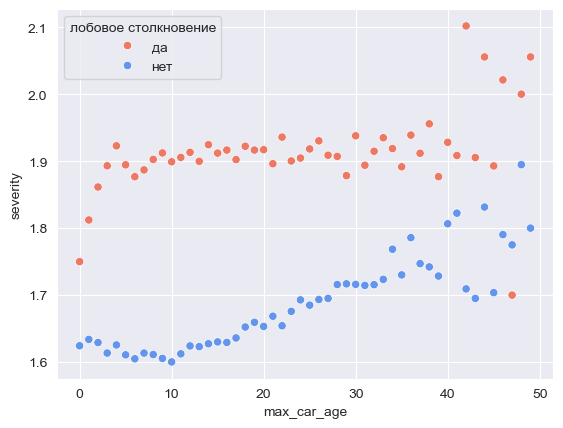

In [79]:
dtp_lob_overall['лобовое столкновение'] = dtp_lob_overall['is_lob'].map({
    1: 'да',
    0: 'нет'
})

sns.scatterplot(
    data=dtp_lob_overall,
    x='max_car_age',
    y='severity',
    hue='лобовое столкновение',     palette={
        'нет': '#6495ed',   # синий
        'да': '#ed7864'  # красный
    }
)

In [80]:
dtp_lob_fort = dtp_lob_mean.merge(dtp_not_lob_mean, on = 'max_car_age')

In [81]:
dtp_lob_fort

,max_car_age,is_lob_x,severity_x,is_lob_y,severity_y
0,0,1,1.750000,0,1.624388
1,1,1,1.812169,0,1.633864
2,2,1,1.861373,0,1.629189
3,3,1,1.893052,0,1.613492
4,4,1,1.922869,0,1.625605
5,5,1,1.894470,0,1.610829
6,6,1,1.876772,0,1.604947
7,7,1,1.886915,0,1.613478
8,8,1,1.902549,0,1.611257
9,9,1,1.912244,0,1.605518


In [82]:
compare_mean(dtp_lob_fort, 'severity_x', 'severity_y')

Дисперсии выборок не равны
p_normal_means_s1: 0.5500534403561885
p_normal_means_s12: 0.464135025006765
p_equal_var: 0.01542438929583024
Т-Критерий Уэлча
p-value: 4.8336345087898695e-30
Средние стат. значимо отличаются


                            OLS Regression Results                            
Dep. Variable:               severity   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     4.394
Date:                Tue, 16 Dec 2025   Prob (F-statistic):             0.0414
Time:                        08:53:06   Log-Likelihood:                 72.741
No. Observations:                  50   AIC:                            -141.5
Df Residuals:                      48   BIC:                            -137.7
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.8692      0.017    111.386      

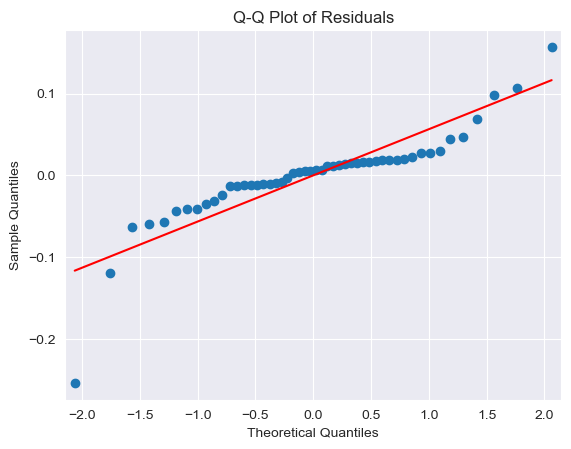

Breusch-Pagan Test for Homoscedasticity: p-value=0.0288
Residuals are heteroscedastic.


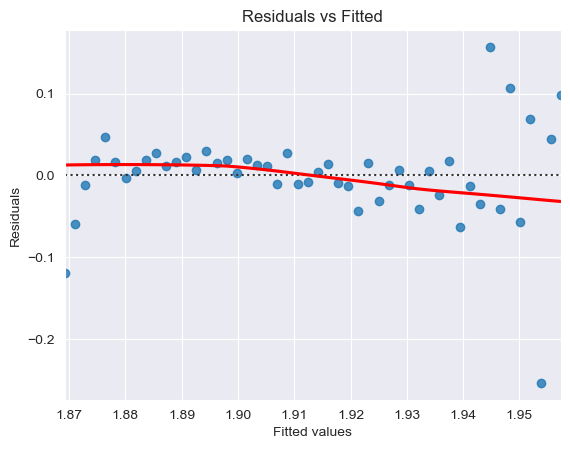

In [83]:
check_linear_regression(dtp_lob_mean, 'severity', 'max_car_age')

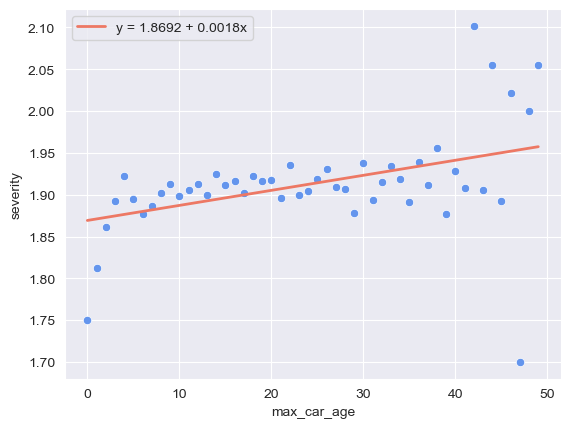

In [84]:
sns.scatterplot(data = dtp_lob_mean, x = 'max_car_age', y = 'severity', color = '#6495ed')

x_vals = np.linspace(dtp_lob_mean['max_car_age'].min(),
                     dtp_lob_mean['max_car_age'].max(), 100)

y_vals = 1.8692 + 0.0018 * x_vals

plt.plot(x_vals, y_vals, linewidth=2, label='y = 1.8692 + 0.0018x', color = '#ed7864')

plt.legend()
plt.show()

In [85]:
dtp_lob_mean.corr(numeric_only = True, method = 'pearson')

,max_car_age,is_lob,severity
max_car_age,1.000000,NaN,0.417422
is_lob,NaN,NaN,NaN
severity,0.417422,NaN,1.000000


                            OLS Regression Results                            
Dep. Variable:               severity   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     99.06
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           2.95e-13
Time:                        08:53:06   Log-Likelihood:                 101.79
No. Observations:                  50   AIC:                            -199.6
Df Residuals:                      48   BIC:                            -195.8
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.5834      0.009    177.525      

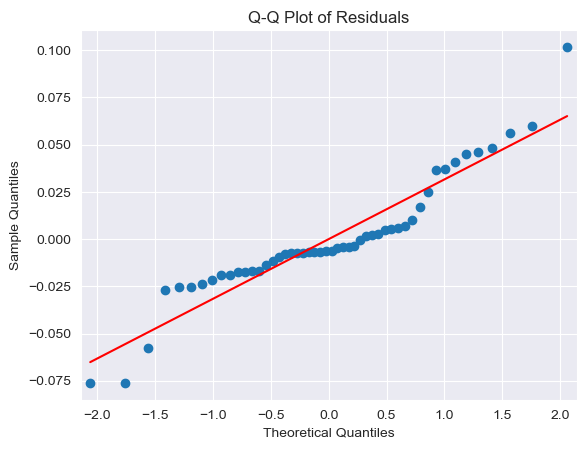

Breusch-Pagan Test for Homoscedasticity: p-value=0.0047
Residuals are heteroscedastic.


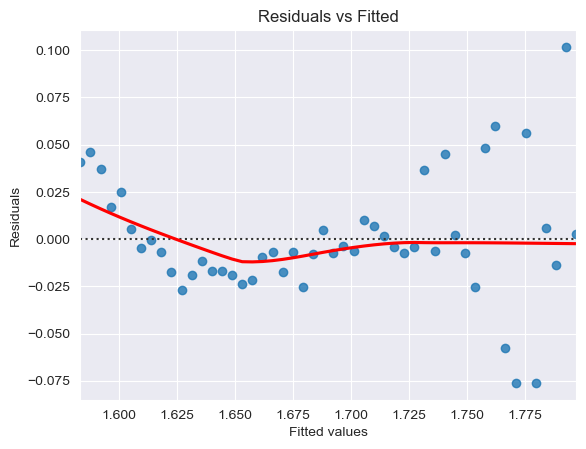

In [86]:
check_linear_regression(dtp_not_lob_mean, 'severity', 'max_car_age')

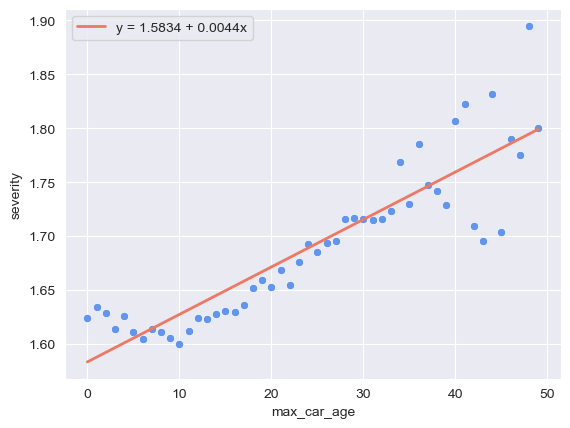

In [87]:
sns.scatterplot(data = dtp_not_lob_mean, x = 'max_car_age', y = 'severity', color = '#6495ed')

x_vals = np.linspace(dtp_not_lob_mean['max_car_age'].min(),
                     dtp_not_lob_mean['max_car_age'].max(), 100)

y_vals = 1.5834 + 0.0044 * x_vals

plt.plot(x_vals, y_vals, linewidth=2, label='y = 1.5834 + 0.0044x', color = '#ed7864')

plt.legend()
plt.show()

In [88]:
dtp_not_lob_mean.corr(numeric_only = True, method = 'pearson')

,max_car_age,is_lob,severity
max_car_age,1.000000,NaN,0.893913
is_lob,NaN,NaN,NaN
severity,0.893913,NaN,1.000000
